In [1]:
import pandas as pd
import numpy as np
import IPython.display as ipd
import os
import os.path
from pathlib import Path
import glob

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
Main_WAV_Path = Path(r'C:\Users\user\Desktop\TESS Toronto emotional speech set data')

In [3]:
Wav_Path = list(Main_WAV_Path.glob(r"**/*.wav"))

In [4]:
Wav_Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],Wav_Path))

In [5]:
Wav_Path_Series = pd.Series(Wav_Path,name="WAV").astype(str)
Wav_Labels_Series = pd.Series(Wav_Labels,name="EMOTION")

In [6]:
Main_Wav_Data = pd.concat([Wav_Path_Series,Wav_Labels_Series],axis=1)

In [7]:
print(Main_Wav_Data.head(-1))

                                                    WAV    EMOTION
0     C:\Users\user\Desktop\TESS Toronto emotional s...  OAF_angry
1     C:\Users\user\Desktop\TESS Toronto emotional s...  OAF_angry
2     C:\Users\user\Desktop\TESS Toronto emotional s...  OAF_angry
3     C:\Users\user\Desktop\TESS Toronto emotional s...  OAF_angry
4     C:\Users\user\Desktop\TESS Toronto emotional s...  OAF_angry
...                                                 ...        ...
2794  C:\Users\user\Desktop\TESS Toronto emotional s...    YAF_sad
2795  C:\Users\user\Desktop\TESS Toronto emotional s...    YAF_sad
2796  C:\Users\user\Desktop\TESS Toronto emotional s...    YAF_sad
2797  C:\Users\user\Desktop\TESS Toronto emotional s...    YAF_sad
2798  C:\Users\user\Desktop\TESS Toronto emotional s...    YAF_sad

[2799 rows x 2 columns]


In [8]:
print(Main_Wav_Data["EMOTION"].value_counts())

YAF_fear                  200
YAF_neutral               200
YAF_pleasant_surprised    200
OAF_disgust               200
OAF_Fear                  200
OAF_happy                 200
YAF_disgust               200
OAF_angry                 200
YAF_angry                 200
YAF_happy                 200
OAF_neutral               200
YAF_sad                   200
OAF_Sad                   200
OAF_Pleasant_surprise     200
Name: EMOTION, dtype: int64


In [9]:
Main_Wav_Data = Main_Wav_Data.sample(frac=1).reset_index(drop=True)

In [10]:
print(Main_Wav_Data.head(-1))

                                                    WAV  \
0     C:\Users\user\Desktop\TESS Toronto emotional s...   
1     C:\Users\user\Desktop\TESS Toronto emotional s...   
2     C:\Users\user\Desktop\TESS Toronto emotional s...   
3     C:\Users\user\Desktop\TESS Toronto emotional s...   
4     C:\Users\user\Desktop\TESS Toronto emotional s...   
...                                                 ...   
2794  C:\Users\user\Desktop\TESS Toronto emotional s...   
2795  C:\Users\user\Desktop\TESS Toronto emotional s...   
2796  C:\Users\user\Desktop\TESS Toronto emotional s...   
2797  C:\Users\user\Desktop\TESS Toronto emotional s...   
2798  C:\Users\user\Desktop\TESS Toronto emotional s...   

                     EMOTION  
0     YAF_pleasant_surprised  
1                  YAF_happy  
2      OAF_Pleasant_surprise  
3     YAF_pleasant_surprised  
4                  OAF_angry  
...                      ...  
2794             YAF_disgust  
2795             YAF_disgust  
2796        

In [11]:
def add_noise(data):
    noise_value = 0.015 * np.random.uniform() * np.amax(data)
    data = data + noise_value * np.random.normal(size=data.shape[0])
    
    return data

In [12]:
def stretch_process(data,rate=0.8):
    
    return librosa.effects.time_stretch(data,rate)

In [13]:
def shift_process(data):
    shift_range = int(np.random.uniform(low=-5,high=5) * 1000)
    
    return np.roll(data,shift_range)

In [14]:
def pitch_process(data,sampling_rate,pitch_factor=0.7):
    
    return librosa.effects.pitch_shift(data,sampling_rate,pitch_factor)

In [15]:
def extract_process(data):
    
    output_result = np.array([])
    mean_zero = np.mean(librosa.feature.zero_crossing_rate(y=data).T,axis=0)
    output_result = np.hstack((output_result,mean_zero))
    
    stft_out = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft_out,sr=sample_rate).T,axis=0)
    output_result = np.hstack((output_result,chroma_stft))
    
    mfcc_out = np.mean(librosa.feature.mfcc(y=data,sr=sample_rate).T,axis=0)
    output_result = np.hstack((output_result,mfcc_out))
    
    root_mean_out = np.mean(librosa.feature.rms(y=data).T,axis=0)
    output_result = np.hstack((output_result,root_mean_out))
    
    mel_spectogram = np.mean(librosa.feature.melspectrogram(y=data,sr=sample_rate).T,axis=0)
    output_result = np.hstack((output_result,mel_spectogram))
    
    return output_result

In [16]:
def export_process(path):
    
    data,sample_rate = librosa.load(path,duration=2.5,offset=0.6)
    
    output_1 = extract_process(data)
    result = np.array(output_1)
    
    noise_out = add_noise(data)
    output_2 = extract_process(noise_out)
    result = np.vstack((result,output_2))
    
    new_out = stretch_process(data)
    strectch_pitch = pitch_process(new_out,sample_rate)
    output_3 = extract_process(strectch_pitch)
    result = np.vstack((result,output_3))
    
    return result

In [17]:
from scipy.io.wavfile import read, write

In [18]:
rate,speech = read(Main_Wav_Data["WAV"][2342])
print(Main_Wav_Data["EMOTION"][2342])

Audio(speech,rate=rate,autoplay=False)

OAF_disgust


In [19]:
rate,speech = read(Main_Wav_Data["WAV"][3])
print(Main_Wav_Data["EMOTION"][3])

Audio(speech,rate=rate,autoplay=False)

YAF_pleasant_surprised


In [20]:
rate,speech = read(Main_Wav_Data["WAV"][2795])
print(Main_Wav_Data["EMOTION"][2795])

Audio(speech,rate=rate,autoplay=False)

YAF_disgust


In [21]:
rate,speech = read(Main_Wav_Data["WAV"][2795])
print(Main_Wav_Data["EMOTION"][2795])
print(speech.shape)
print(speech.dtype)
print(rate)

YAF_disgust
(57904,)
int16
24414


In [22]:
rate,speech = read(Main_Wav_Data["WAV"][314])
print(Main_Wav_Data["EMOTION"][314])
print(speech.shape)
print(speech.dtype)
print(rate)

YAF_neutral
(50473,)
int16
24414


In [23]:
rate,speech = read(Main_Wav_Data["WAV"][134])
print(Main_Wav_Data["EMOTION"][134])
print(speech.shape)
print(speech.dtype)
print(rate)

YAF_angry
(52036,)
int16
24414


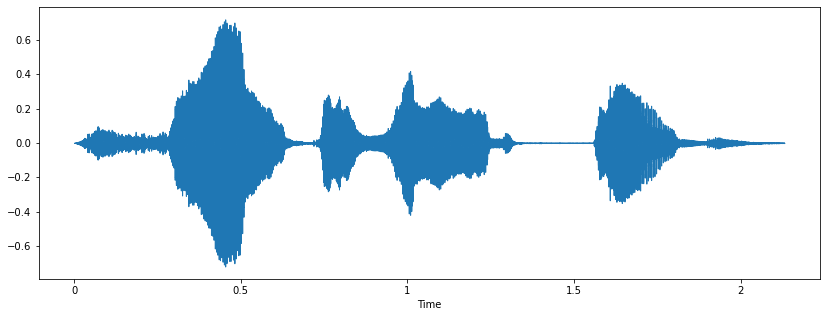

In [24]:
figure = plt.figure(figsize=(14,5))

audio_speech,rate = librosa.load(Main_Wav_Data["WAV"][134])
librosa.display.waveshow(audio_speech,sr=rate)
Audio(audio_speech,rate=rate)

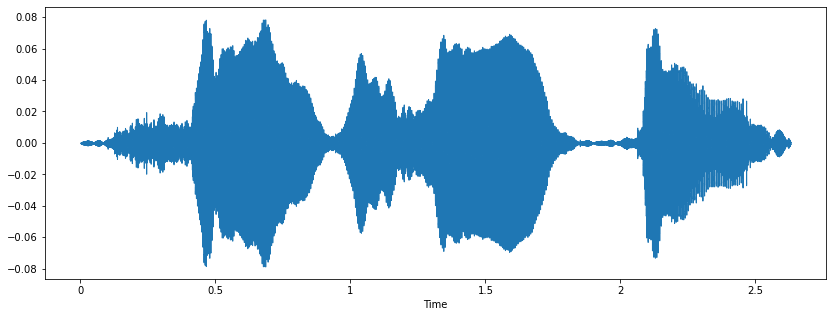

In [25]:
figure = plt.figure(figsize=(14,5))

audio_speech,rate = librosa.load(Main_Wav_Data["WAV"][34])
librosa.display.waveshow(audio_speech,sr=rate)
Audio(audio_speech,rate=rate)

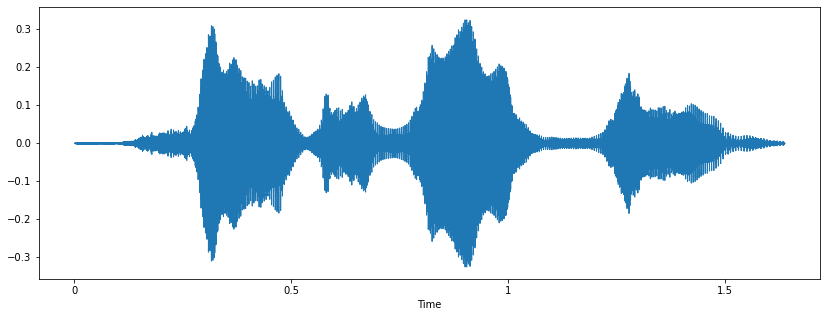

In [26]:
figure = plt.figure(figsize=(14,5))

audio_speech,rate = librosa.load(Main_Wav_Data["WAV"][4])
librosa.display.waveshow(audio_speech,sr=rate)
Audio(audio_speech,rate=rate)

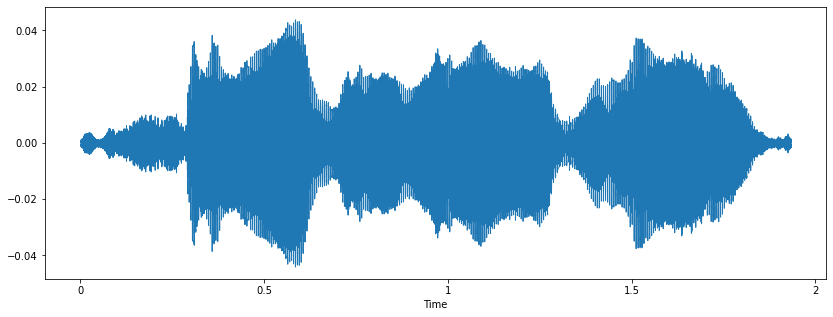

In [27]:
figure = plt.figure(figsize=(14,5))

audio_speech,sample_rate = librosa.load(Main_Wav_Data["WAV"][2000])

noise_injection = add_noise(audio_speech)

librosa.display.waveshow(noise_injection,sr=sample_rate)
Audio(noise_injection,rate=sample_rate)

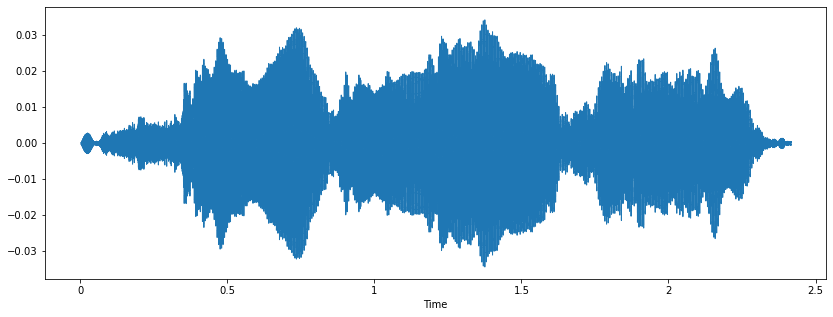

In [28]:
figure = plt.figure(figsize=(14,5))

audio_speech,sample_rate = librosa.load(Main_Wav_Data["WAV"][2000])

stretching_audio = stretch_process(audio_speech)
librosa.display.waveshow(stretching_audio,sr=sample_rate)
Audio(stretching_audio,rate=sample_rate)

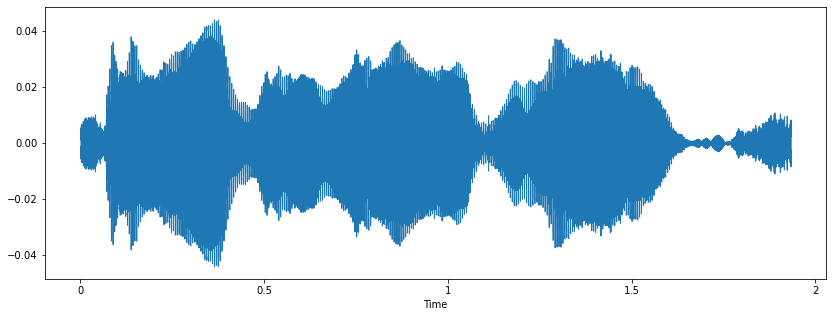

In [29]:
figure = plt.figure(figsize=(14,5))

audio_speech,sample_rate = librosa.load(Main_Wav_Data["WAV"][2000])

shifting_audio = shift_process(audio_speech)
librosa.display.waveshow(shifting_audio,sr=sample_rate)
Audio(shifting_audio,rate=sample_rate)

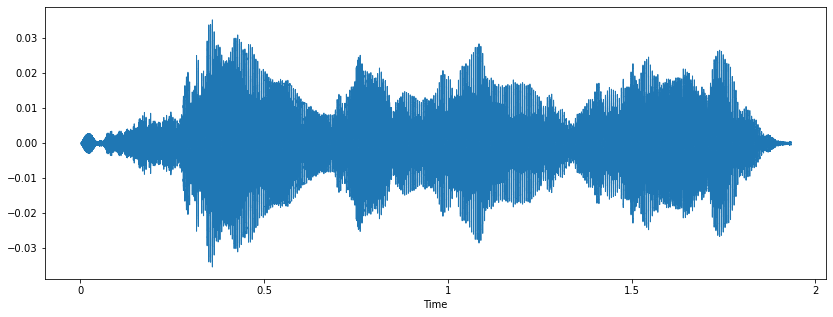

In [30]:
figure = plt.figure(figsize=(14,5))

audio_speech,sample_rate = librosa.load(Main_Wav_Data["WAV"][2000])

pitch_audio = pitch_process(audio_speech,sample_rate)
librosa.display.waveshow(pitch_audio,sr=sample_rate)
Audio(pitch_audio,rate=sample_rate)

In [31]:
x_Train, y_Train = [],[]

for path,emotion in zip(Main_Wav_Data.WAV,Main_Wav_Data.EMOTION):
    
    features = export_process(path)
    
    for element in features:
        x_Train.append(element)
        y_Train.append(emotion)

In [32]:
print(len(x_Train))
print(len(y_Train))
print(len(Main_Wav_Data.WAV))

8400
8400
2800


In [33]:
print(x_Train[0].shape)

(162,)


In [34]:
print(y_Train[0:5])

['YAF_pleasant_surprised', 'YAF_pleasant_surprised', 'YAF_pleasant_surprised', 'YAF_happy', 'YAF_happy']


In [35]:
New_Features_Wav = pd.DataFrame(x_Train)
New_Features_Wav["EMOTIONS"] = y_Train

New_Features_Wav.to_csv("New_Wav_Set.csv",index=False)

In [36]:
New_Features_Wav.head(-1)

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,EMOTIONS
0,0.107342,0.476348,0.480148,0.426969,0.360762,0.410295,0.450261,0.469705,0.516147,0.493480,...,0.000267,0.000362,0.000405,0.000450,0.000320,0.000103,0.000024,3.936681e-06,3.419241e-07,YAF_pleasant_surprised
1,0.115195,0.491517,0.476692,0.402404,0.402396,0.475634,0.464219,0.505444,0.508854,0.555360,...,0.000348,0.000431,0.000486,0.000521,0.000397,0.000175,0.000098,8.295088e-05,7.315178e-05,YAF_pleasant_surprised
2,0.124165,0.489773,0.549953,0.530551,0.397061,0.385057,0.458823,0.461830,0.544686,0.528677,...,0.000105,0.000060,0.000063,0.000110,0.000073,0.000060,0.000012,4.870893e-07,1.106236e-07,YAF_pleasant_surprised
3,0.115186,0.575307,0.566793,0.625674,0.579616,0.385444,0.406692,0.464980,0.472783,0.433089,...,0.000834,0.000258,0.000399,0.000665,0.000517,0.000193,0.000034,1.851125e-06,2.160449e-08,YAF_happy
4,0.164570,0.558222,0.579520,0.597525,0.613302,0.436879,0.419277,0.457361,0.470411,0.436659,...,0.000877,0.000291,0.000442,0.000710,0.000555,0.000235,0.000064,3.828613e-05,3.778098e-05,YAF_happy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8394,0.051614,0.467596,0.433684,0.467106,0.519070,0.608986,0.670481,0.513434,0.437149,0.400765,...,0.000180,0.000207,0.000152,0.000120,0.000102,0.000059,0.000014,1.339513e-06,1.549625e-08,OAF_Pleasant_surprise
8395,0.076423,0.505674,0.470586,0.498453,0.551538,0.637394,0.687277,0.542628,0.471342,0.442106,...,0.000208,0.000236,0.000178,0.000150,0.000132,0.000091,0.000048,3.502701e-05,3.074183e-05,OAF_Pleasant_surprise
8396,0.071214,0.422188,0.489100,0.445543,0.442919,0.498628,0.558324,0.703740,0.608307,0.454377,...,0.000029,0.000043,0.000050,0.000049,0.000029,0.000020,0.000005,2.155865e-07,3.538559e-09,OAF_Pleasant_surprise
8397,0.085538,0.484576,0.472920,0.419858,0.424442,0.531902,0.409122,0.371233,0.442921,0.492213,...,0.002060,0.001987,0.000987,0.000504,0.000453,0.000169,0.000037,4.605646e-06,1.326100e-06,YAF_angry


In [37]:
print(New_Features_Wav["EMOTIONS"].value_counts())

OAF_disgust               600
YAF_disgust               600
OAF_angry                 600
OAF_neutral               600
YAF_sad                   600
OAF_Pleasant_surprise     600
YAF_fear                  600
YAF_neutral               600
YAF_pleasant_surprised    600
OAF_Fear                  600
OAF_happy                 600
YAF_angry                 600
YAF_happy                 600
OAF_Sad                   600
Name: EMOTIONS, dtype: int64


In [38]:
encoder_label = OneHotEncoder()

In [39]:
scaler_data = StandardScaler()

In [40]:
X = New_Features_Wav.iloc[:,:-1].values
Y = New_Features_Wav["EMOTIONS"].values

In [41]:
print(X.shape)
print(Y.shape)

(8400, 162)
(8400,)


In [ ]:
Y = encoder_label.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [43]:
print(Y.shape)

(8400, 14)


In [44]:
xTrain,xTest,yTrain,yTest = train_test_split(X,Y,train_size=0.9,random_state=42,shuffle=True)

In [45]:
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)

(7560, 162)
(7560, 14)
(840, 162)
(840, 14)


In [46]:
xTrain = scaler_data.fit_transform(xTrain)
xTest = scaler_data.transform(xTest)

In [47]:
print(xTrain.shape)
print(xTest.shape)

(7560, 162)
(840, 162)


In [48]:
xTrain = np.expand_dims(xTrain,axis=2)
xTest = np.expand_dims(xTest,axis=2)

In [49]:
print(xTrain.shape)
print(xTest.shape)

(7560, 162, 1)
(840, 162, 1)


In [50]:
Model=Sequential()
Model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(xTrain.shape[1], 1)))
Model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

Model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
Model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

Model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
Model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
Model.add(Dropout(0.2))

Model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
Model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

Model.add(Flatten())
Model.add(Dense(units=32, activation='relu'))
Model.add(Dropout(0.3))

Model.add(Dense(units=14, activation='softmax'))

In [51]:
Model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

In [52]:
import tensorflow as tf

In [53]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=Model.fit(xTrain, yTrain, batch_size=64, epochs=200, validation_data=(xTest, yTest), callbacks=[rlrp])

Epoch 1/200
119/119 [==============================] - 37s 303ms/step - loss: 1.9807 - accuracy: 0.3513 - val_loss: 0.9758 - val_accuracy: 0.7357
Epoch 2/200
119/119 [==============================] - 38s 316ms/step - loss: 0.9511 - accuracy: 0.6832 - val_loss: 0.4017 - val_accuracy: 0.8560
Epoch 3/200
119/119 [==============================] - 35s 298ms/step - loss: 0.6495 - accuracy: 0.7783 - val_loss: 0.2430 - val_accuracy: 0.9190
Epoch 4/200
119/119 [==============================] - 34s 289ms/step - loss: 0.4957 - accuracy: 0.8228 - val_loss: 0.1810 - val_accuracy: 0.9381
Epoch 5/200
119/119 [==============================] - 35s 291ms/step - loss: 0.4171 - accuracy: 0.8528 - val_loss: 0.1554 - val_accuracy: 0.9488
Epoch 6/200
119/119 [==============================] - 37s 307ms/step - loss: 0.3411 - accuracy: 0.8821 - val_loss: 0.1341 - val_accuracy: 0.9452
Epoch 7/200
119/119 [==============================] - 36s 304ms/step - loss: 0.3440 - accuracy: 0.8833 - val_loss: 0.1084 -

In [54]:
Model_Results = Model.evaluate(xTest,yTest)
print("LOSS:  " + "%.4f" % Model_Results[0])
print("ACCURACY:  " + "%.4f" % Model_Results[1])

27/27 [==============================] - 1s 33ms/step - loss: 0.0380 - accuracy: 0.9940
LOSS:  0.0380
ACCURACY:  0.9940


In [55]:
prediction_test = Model.predict(xTest)
y_prediction = encoder_label.inverse_transform(prediction_test)

yTest = encoder_label.inverse_transform(yTest)

In [56]:
print(prediction_test[0:10])

[[7.76582909e-28 1.56172841e-30 1.00000000e+00 3.16204802e-27
  1.06272499e-12 8.31508402e-25 3.23619931e-24 0.00000000e+00
  3.98707835e-26 9.52975164e-35 8.45805989e-31 5.55789880e-25
  0.00000000e+00 1.36840687e-17]
 [7.92962070e-17 4.17385312e-17 9.58435275e-30 1.00000000e+00
  1.77148603e-16 2.07726343e-17 1.75931188e-29 9.08389731e-18
  2.04961261e-16 1.81648992e-20 2.40927489e-15 1.12658957e-28
  6.18719001e-19 8.71555838e-26]
 [3.44380295e-22 9.31473344e-16 9.91587800e-35 3.69042192e-14
  4.33348320e-26 8.37718763e-28 4.11120062e-38 1.00000000e+00
  1.58945337e-08 6.25496981e-18 5.60575163e-11 5.98583533e-27
  3.62736142e-15 2.84560109e-19]
 [8.26331843e-18 5.86262011e-11 5.24157554e-18 4.08672512e-10
  1.21474004e-08 6.21017632e-18 3.84201904e-20 2.91793367e-10
  9.99999881e-01 7.78428190e-19 1.40115160e-13 1.77909716e-13
  1.02918840e-07 2.94460880e-13]
 [2.78932982e-25 9.39491263e-10 9.22742618e-36 1.31595386e-17
  1.80869460e-23 1.22610216e-19 1.84542777e-26 2.51603289e-08


In [57]:
print(y_prediction[0:10])

[['OAF_Sad']
 ['OAF_angry']
 ['YAF_angry']
 ['YAF_disgust']
 ['YAF_pleasant_surprised']
 ['OAF_angry']
 ['YAF_sad']
 ['YAF_neutral']
 ['OAF_angry']
 ['OAF_angry']]


In [58]:
print(yTest[0:10])

[['OAF_Sad']
 ['OAF_angry']
 ['YAF_angry']
 ['YAF_disgust']
 ['YAF_pleasant_surprised']
 ['OAF_angry']
 ['YAF_sad']
 ['YAF_neutral']
 ['OAF_angry']
 ['OAF_angry']]


In [59]:
from sklearn.metrics import accuracy_score

In [60]:
print(accuracy_score(yTest, y_prediction))

0.9940476190476191


In [447]:
new_predict_list = []
feat_new = export_process(r"C:\Users\user\Desktop\TESS Toronto emotional speech set data\OAF_happy\OAF_bought_happy.wav")

for feat in feat_new:
    new_predict_list.append(feat)
    

In [ ]:
print(new_predict_list[1].shape)

In [449]:
New_Predict_Feat = pd.DataFrame(new_predict_list)

In [450]:
New_Predict_Feat = scaler_data.fit_transform(New_Predict_Feat)
New_Predict_Feat = np.expand_dims(New_Predict_Feat,axis=2)


In [451]:
print(New_Predict_Feat.shape)

(3, 162, 1)


In [452]:
prediction_nonseen = Model.predict(New_Predict_Feat)
arg_prediction_nonseen = prediction_nonseen.argmax(axis=-1)
y_prediction_nonseen = encoder_label.inverse_transform(prediction_nonseen)

In [453]:
print(arg_prediction_nonseen)
print(y_prediction_nonseen)

[9 9 5]
[['YAF_fear']
 ['YAF_fear']
 ['OAF_happy']]


In [706]:
#RECORDED USING MICROPHONE:
import pyaudio
import wave

CHUNK = 1024 
FORMAT = pyaudio.paInt16 #paInt8
CHANNELS = 2 
RATE = 44100 #sample rate
RECORD_SECONDS = 4
WAVE_OUTPUT_FILENAME = "output10.wav"

p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK) #buffer

print("* recording")
frames = []
decoded=[]

for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    decoded.append(np.fromstring(data,'Float32'))
    frames.append(data) # 2 bytes(16 bits) per channel

print("* done recording")

stream.stop_stream()
stream.close()
p.terminate()

wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()

* recording
* done recording


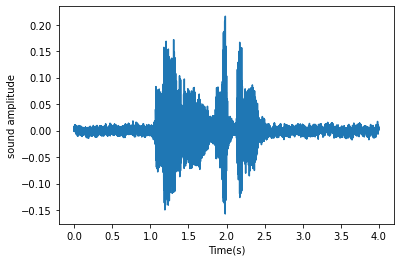

In [707]:
fname = 'output10.wav'
data, sampling_rate = librosa.load(fname)

time = np.arange(0,len(data)) / sampling_rate
fig, ax = plt.subplots()
ax.plot(time, data)
ax.set(xlabel='Time(s)',ylabel='sound amplitude')

# Lets play the audio 
ipd.Audio(fname)

In [708]:
new_predict_list = []
feat_new = export_process("output10.wav")

for feat in feat_new:
    new_predict_list.append(feat)

In [709]:
print(new_predict_list[0].shape)

(162,)


In [710]:
New_Predict_Feat = pd.DataFrame(new_predict_list)

In [711]:
New_Predict_Feat = scaler_data.fit_transform(New_Predict_Feat)
New_Predict_Feat = np.expand_dims(New_Predict_Feat,axis=2)

In [712]:
print(New_Predict_Feat.shape)

(3, 162, 1)


In [713]:
prediction_nonseen = Model.predict(New_Predict_Feat)
arg_prediction_nonseen = prediction_nonseen.argmax(axis=-1)
y_prediction_nonseen = encoder_label.inverse_transform(prediction_nonseen)

In [714]:
print(arg_prediction_nonseen)
print(y_prediction_nonseen)

[ 2 11  4]
[['OAF_Sad']
 ['YAF_neutral']
 ['OAF_disgust']]
